# <center><font color='blue'>SkimLit</center></font>

## Tabla de contenido
- [1 - Goals](#1)
- [2 - Understanding the problem](#2)
- [3 - Libraries](#3)
- [4 - Helper functions](#4)
- [4 - Data loading and visualization](#5)
- [6 - Data preprocessing](#6)
- [7 - Models](#7)
    - [7.1. - Model 1: Conv1D](#7.1)
    - [7.2. - Modelo 2: Feature extraction with pre-trained token embeddings](#7.2)
    - [7.3. - Modelo 3: Conv1D with character embeddings](#7.3)
    - [7.4. - Modelo 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer](#7.4)
    - [7.5. - Modelo 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings](#7.5)
- [8 - Compare model results](#8)
- [9 - References](#9)


<a name="1"></a>
## <font color = '#800080'> 1. Goals </font>


The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

📖 **Resource:** If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb


<img src="images/goal.png"/>

<br>

<img src="images/goal2.png"/>


<a name="2"></a>
## <font color = '#800080'> 2. Understanding the problem </font>

<img src="images/inputs_outputs.png">


<img src="images/inputs_outputs2.png">


SkimLit será many to one (a muchas palabras les corresponderá una etiqueta (background, methoids, results..)):

<img src="images/seq_problems.png"/>


<a name="3"></a>
## <font color = '#800080'> 3. Libraries </font>

In [4]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [5]:
import os
import random
from datetime import datetime
import re
import csv

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, models, Sequential, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_hub as hub
import keras_tuner
from keras import backend as K


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import string
from keras.utils import plot_model

<a name="4"></a>
## <font color = '#800080'> 4. Helper Functions </font>


### Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper function script: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

--2024-01-04 16:03:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[2606:50c0:8001::154]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 10246 (10K) [text/plain]
Guardando como: ‘helper_functions.py.6’

helper_functions.py 100%[===================>]  10,01K  --.-KB/s    en 0,001s  

2024-01-04 16:03:55 (14,6 MB/s) - ‘helper_functions.py.6’ guardado [10246/10246]



In [7]:
from helper_functions import calculate_results

<a name="5"></a>
## <font color = '#800080'> 5. Data loading and visualization </font>


Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct 

In [8]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: la ruta de destino 'pubmed-rct' ya existe y no es un directorio vacío.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


hay uno con 20.000 ejemplos (útil para las primeras pruebas) y otro con 200k

In [9]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [10]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [11]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [12]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [13]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

vemos que los abstracts arrancan con "###", le sigue un id, un salto de linea, cada sentncia tiene una etiqueta (comienza etiqueta y luego \t) y el final está indicado por '\n'

<br>

necesitamos una función que separe el texto de las etiquetas y los diferentes abstracts

<a name="6"></a>
## <font color = '#800080'> 6. Data preprocessing </font>

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
   ...]
```

total lines es la cantidad de líneas en el abstract (que queremos clasificar secuencialmente)

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [14]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [15]:
# Get data from file and preprocess it
#%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [16]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [17]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [18]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

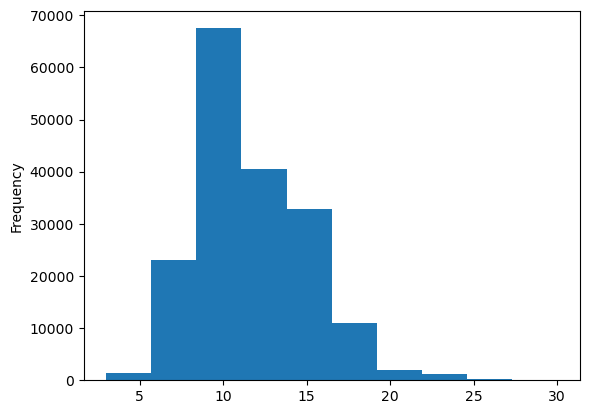

In [19]:
# Let's check the length of different lines
train_df.total_lines.plot.hist(); 

In [20]:
# get list of sentences

# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [21]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML models require numeric labels)

In [22]:
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
# aqui no hay fit, se ajusta sólo en train
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot


# tf.one_hot de TF

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#### Encode labels

In [23]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Baseline

In [25]:
# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [27]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [28]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [29]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [30]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

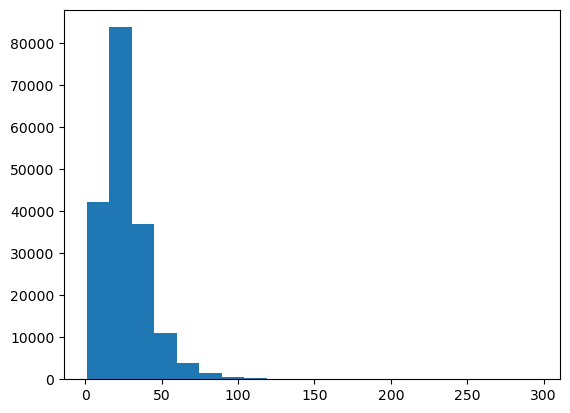

In [31]:
# What's the distribution look like?
plt.hist(sent_lens, bins=20);

In [32]:
# How long of a setnence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [33]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

The TextVectorization layer accepts raw text as input and converts it into a numerical representation suitable for deep learning models. This process is accomplished by tokenizing the input text, meaning it's broken down into individual words or phrases. These smaller units, or tokens, are then assigned integer values for further processing. A simple workflow is illustrated below where a sample text, "TensorFlow is great for NLP" is processed in the TextVectorization layer, and the resulting output is an integer representation of those words. 


<img src="images/text_vectorizer.png"/>

The TextVectorization layer also provides options for customizing the preprocessing step before vectorizing the text. These options include removing punctuation, converting all letters to lowercase, filtering out stopwords, and more.

Some of the parameters for the TextVectorization layer include:

    max_tokens: 
        The maximum number of tokens to generate when tokenizing text. This represents the maximum size of the vocabulary.
    
    output_mode: How the output should be returned.
    
    standardize: Whether to apply standardization techniques (such as converting to lowercase) to the input data.
    
    output_sequence_length: The desired length of each sequence after tokenizing and preprocessing is completed.




https://app.dataquest.io/m/793/text-vectorizer-and-word-embeddings/2/text-vectorization-in-tensorflow

https://developers.google.com/machine-learning/guides/text-classification/step-3?hl=es-419

In [34]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [35]:
# Create text vectorizer


text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [36]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [37]:
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
patients with locally recurrent/metastatic uc and adequate organ function who achieved stable disease or a partial or complete response after @ to @ chemotherapy cycles were randomized to sunitinib at a dose of @ mg/day ( @ days on and @ days off ) or placebo .

Length of text: 47

Vectorized text: [[   12     7  2575 24864  1761     3  1389  1834   149    67   454   729
    114    16     8  1049    16   488   142    21     6   415  1039     9
     29     6  3586    15     8   131     4   744    84    18     3    84
   2396    16    48     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


observemos que rellena con 0s hasta la longitud de salida especificada (ouput_seq_length(=55 en este caso))

In [38]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

<img src="images/embedding_layer.png"/>

"the mouse ran up the clock" equivale a 1,2,3,4,1,5 pues the es 1, mouse 2, ran 3, up 4 y clock 5

la capa de embedding con dimensión de salida 4, tiene 4 elementos para cada palabra, por ejemplo el de
"1" (que es "the") es 0.236 -0.141 0.000 0.045


In [40]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically differnt 
                                               #numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space),
                               name="token_embedding")

In [41]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 patients with locally recurrent/metastatic uc and adequate organ function who achieved stable disease or a partial or complete response after @ to @ chemotherapy cycles were randomized to sunitinib at a dose of @ mg/day ( @ days on and @ days off ) or placebo .

Sentence after vectorization (before embedding):
 [[   12     7  2575 24864  1761     3  1389  1834   149    67   454   729
    114    16     8  1049    16   488   142    21     6   415  1039     9
     29     6  3586    15     8   131     4   744    84    18     3    84
   2396    16    48     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.04126474  0.04846122  0.02487785 ...  0.01806618  0.04355489
    0.00488037]
  [-0.01250559 -0.03011186 -0.02821821 ...  0.00880392  0.04291291
   -0.03495535]
  [ 0.03014431 -0.00141902  0.01015564 ... -0.03031433  0.02218776
   -0.01312125]
  ...
  [-0.02500912  0.04779664  0.

### Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [42]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

<img src="images/prefetching.png">

In [43]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

<a name="7"></a>
## <font color = '#800080'> 7. Models </font>

In [44]:
tf.random.set_seed(42)

<a name="7.1"></a>
### <font color = 'orange'> 7.1. Model 1: Conv1D </font> 

In [45]:
INPUT_SHAPE=(1,)
BATCH_SIZE = 32

In [46]:


def build_model_1(input_shape,num_classes,name):
    inputs = layers.Input(shape=input_shape,dtype=tf.string)
    x = text_vectorizer(inputs)
    x = token_embed(x)
    x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs,name=name)
    return model

    
    
model_1 = build_model_1(INPUT_SHAPE,num_classes,'model_1')
    


In [47]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325 

In [48]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(), # etiquetas one-hot
    metrics=['accuracy']
)


history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    #batch_size=BATCH_SIZE,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)


Epoch 1/3
562/562 [==============================] - 61s 108ms/step - loss: 0.9261 - accuracy: 0.6345 - val_loss: 0.6972 - val_accuracy: 0.7344
Epoch 2/3
562/562 [==============================] - 59s 104ms/step - loss: 0.6663 - accuracy: 0.7528 - val_loss: 0.6418 - val_accuracy: 0.7676
Epoch 3/3
562/562 [==============================] - 59s 105ms/step - loss: 0.6239 - accuracy: 0.7726 - val_loss: 0.6015 - val_accuracy: 0.7842


In [49]:
# evaluate
model_1.evaluate(test_dataset)

942/942 [==============================] - 2s 3ms/step - loss: 0.6167 - accuracy: 0.7807


[0.616662859916687, 0.7807201147079468]

In [50]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 3ms/step


(array([[4.52128291e-01, 1.66714936e-01, 7.31600672e-02, 2.84233540e-01,
         2.37631556e-02],
        [4.18818772e-01, 3.00878972e-01, 1.10206697e-02, 2.62171090e-01,
         7.11066276e-03],
        [1.55043945e-01, 1.39113115e-02, 1.89054117e-03, 8.29123199e-01,
         3.09964889e-05],
        ...,
        [7.60052171e-06, 8.25084397e-04, 8.27160024e-04, 3.14511317e-06,
         9.98337030e-01],
        [6.81969225e-02, 4.83289361e-01, 8.68130773e-02, 7.19685107e-02,
         2.89732218e-01],
        [1.97778806e-01, 6.13639534e-01, 4.76087444e-02, 6.15172945e-02,
         7.94556737e-02]], dtype=float32),
 (30212, 5))

In [51]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [52]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.52177942539387,
 'precision': 0.782400291341341,
 'recall': 0.7852177942539388,
 'f1': 0.783162559369538}

<a name="7.2"></a>
### <font color = 'orange'> 7.2. Model 2: Feature extraction with pre-trained token embeddings</font> 

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [53]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [54]:
# Test out the pretrained embedding on a random sentence 
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 when using torsional phacoemulsification through microincisions and the prefracture technique with the bevel-down technique , the mini-flared @-degree kelman tip required a lower mean phaco time than the reversed mini-flared @-degree kelman tip and the sidewinder @-degree kelman tip .
Setence after embedding:
[ 4.07404696e-05 -4.90045026e-02 -2.91250721e-02 -6.30877987e-02
  2.47004535e-02 -2.42954437e-02  1.93093326e-02  6.16672682e-04
  5.62942699e-02  7.47419372e-02 -6.94030896e-02 -6.37088269e-02
  7.01202545e-03  8.02861229e-02  5.17958924e-02  5.09681664e-02
  5.30055240e-02 -2.32629329e-02  4.77941521e-02 -8.19999129e-02
  3.06099150e-02  6.15166984e-02 -2.82471329e-02  3.52978446e-02
  4.36337106e-03 -4.93948720e-02  3.39503624e-02 -5.20686060e-02
  1.24968635e-02 -1.94124915e-02]

Length of sentence embedding: 512


<img src="images/model_2.png"/>

In [55]:

def build_model_2(input_shape,num_classes,name):
    inputs = layers.Input(shape=input_shape, dtype=tf.string)
    x = tf_hub_embedding_layer()(inputs)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes,activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs,name=name)
    return model


model_2 = build_model_1(INPUT_SHAPE,num_classes,'model_2_USE_feature_extractor')
    
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 5

In [56]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(), # etiquetas one-hot
    metrics=['accuracy']
)


history_model_2 = model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 66s 116ms/step - loss: 0.6668 - accuracy: 0.7585 - val_loss: 0.6140 - val_accuracy: 0.7783
Epoch 2/3
562/562 [==============================] - 70s 125ms/step - loss: 0.5016 - accuracy: 0.8220 - val_loss: 0.5995 - val_accuracy: 0.7846
Epoch 3/3
562/562 [==============================] - 79s 140ms/step - loss: 0.4794 - accuracy: 0.8324 - val_loss: 0.5942 - val_accuracy: 0.7839


In [57]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5969 - accuracy: 0.7864


[0.5968637466430664, 0.7863762974739075]

In [58]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[5.48902988e-01, 1.29551038e-01, 6.88497648e-02, 2.18545675e-01,
        3.41505855e-02],
       [4.24049884e-01, 2.32246399e-01, 1.15848249e-02, 3.27073157e-01,
        5.04579768e-03],
       [9.64668319e-02, 2.65486259e-03, 3.95903975e-04, 9.00478423e-01,
        4.12428471e-06],
       ...,
       [6.95506401e-07, 1.03603474e-04, 1.87790502e-04, 2.34244212e-07,
        9.99707639e-01],
       [8.78329650e-02, 5.33971012e-01, 6.70089424e-02, 7.42580295e-02,
        2.36929074e-01],
       [6.57446608e-02, 8.82695854e-01, 1.83243062e-02, 8.05228855e-03,
        2.51829270e-02]], dtype=float32)

In [59]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [60]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 78.63762743280816,
 'precision': 0.7845829057849641,
 'recall': 0.7863762743280815,
 'f1': 0.7852113966110157}

<a name="7.3"></a>
### <font color = 'orange'> 7.3. Model 3: Conv1D with character embeddings</font> 

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings. 

<img src="images/token_character_Emb.png"/>

### Creating a character-level tokenizer

In [61]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [62]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
#split_chars(random_train_sentence)

In [63]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [64]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

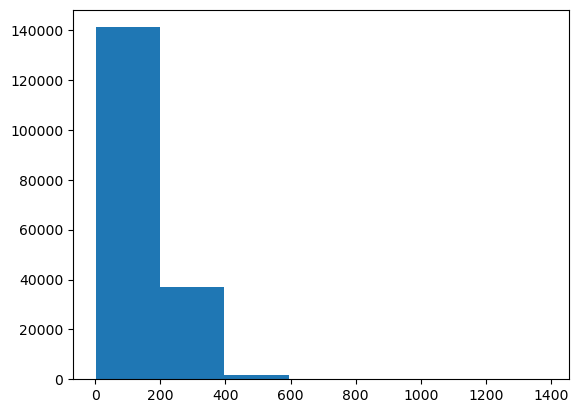

In [65]:
plt.hist(char_lens, bins=7);

In [66]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [67]:
# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standardization to "None" if you want to leave punctuation in
                                    name="char_vectorizer")

In [69]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [70]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [71]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 p d a - c a n c e r   s t e m   c e l l s   (   c s c s   )   a r e   n o t   t a r g e t e d   b y   c u r r e n t   t h e r a p i e s   a n d   m a y   b e   a   r e a s o n   f o r   p o o r   p r o g n o s i s   .

Length of random_train_chars: 89

Vectorized chars:
 [[14 10  5 11  5  6 11  2  8  9  3  2 15 11  2 12 12  9 11  9 11  9  5  8
   2  6  7  3  3  5  8 18  2  3  2 10 22 19 11 16  8  8  2  6  3  3 13  2
   8  5 14  4  2  9  5  6 10 15  5 19 22  2  5  8  2  5  9  7  6 17  7  8
  14  7  7  8 14  8  7 18  6  7  9  4  9  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### Creating a character-level embedding

In [72]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name="char_embed")

In [73]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 p d a - c a n c e r   s t e m   c e l l s   (   c s c s   )   a r e   n o t   t a r g e t e d   b y   c u r r e n t   t h e r a p i e s   a n d   m a y   b e   a   r e a s o n   f o r   p o o r   p r o g n o s i s   .

Embedded chars (after vectorization and embedding):
 [[[-0.04259305  0.04141792 -0.02488533 ... -0.02583377  0.04252789
    0.02171563]
  [-0.03112577 -0.00365621  0.00902804 ... -0.04036019  0.03871908
    0.04863384]
  [-0.0360068   0.0095144   0.03563182 ...  0.02100355 -0.01803361
    0.04069236]
  ...
  [ 0.01990261  0.02734059 -0.00057004 ...  0.03439556  0.01364157
   -0.02117847]
  [ 0.01990261  0.02734059 -0.00057004 ...  0.03439556  0.01364157
   -0.02117847]
  [ 0.01990261  0.02734059 -0.00057004 ...  0.03439556  0.01364157
   -0.02117847]]]

Character embedding shape: (1, 290, 25)


se completa la sentencia hasta que tenga 290 caracteres, y a cada uno le corresponde un embedding de tamaño 25

In [74]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [75]:
def build_model_3(input_shape,num_classes,name):
    inputs = layers.Input(shape=input_shape,dtype=tf.string)
    x = char_vectorizer(inputs)
    x = char_embed(x)
    x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x) # probar MaxPooling!!
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs,name=name)
    return model

    
    
model_3 = build_model_3(INPUT_SHAPE,num_classes,'model_3')
    

In [76]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 5)                 325 

In [77]:
# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 12ms/step - loss: 1.4569 - accuracy: 0.3530 - val_loss: 1.3998 - val_accuracy: 0.4076
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 1.3591 - accuracy: 0.4310 - val_loss: 1.3318 - val_accuracy: 0.4392
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 1.3224 - accuracy: 0.4521 - val_loss: 1.3150 - val_accuracy: 0.4455


In [78]:
model_3.evaluate(test_char_dataset)

942/942 [==============================] - 3s 3ms/step - loss: 1.3181 - accuracy: 0.4480


[1.318062424659729, 0.44795089960098267]

In [79]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.17345008, 0.23164274, 0.29867262, 0.15460348, 0.14163108],
       [0.10668903, 0.15949534, 0.161897  , 0.05907379, 0.51284474],
       [0.08884554, 0.13822535, 0.47437248, 0.09227109, 0.20628549],
       ...,
       [0.05676287, 0.10155094, 0.24156794, 0.04350153, 0.5566167 ],
       [0.04036736, 0.09305295, 0.1964768 , 0.04580342, 0.62429947],
       [0.14881873, 0.18236844, 0.1945818 , 0.06975999, 0.40447113]],
      dtype=float32)

In [80]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 4, 2, ..., 4, 4, 4])>

In [81]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

/home/marcos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 44.98874619356547,
 'precision': 0.3752871802763724,
 'recall': 0.4498874619356547,
 'f1': 0.3922763201446186}

<a name="7.4"></a>
### <font color = 'orange'> 7.4. Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer</font> 


1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`) 
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

idea final, pero en el modelo 4 todavía no

<img src="images/model_4.png"/>

#### Combining token and character data into a tf.data Dataset

In [82]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) 
        # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [83]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [84]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

#### Modelo per-se

In [85]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

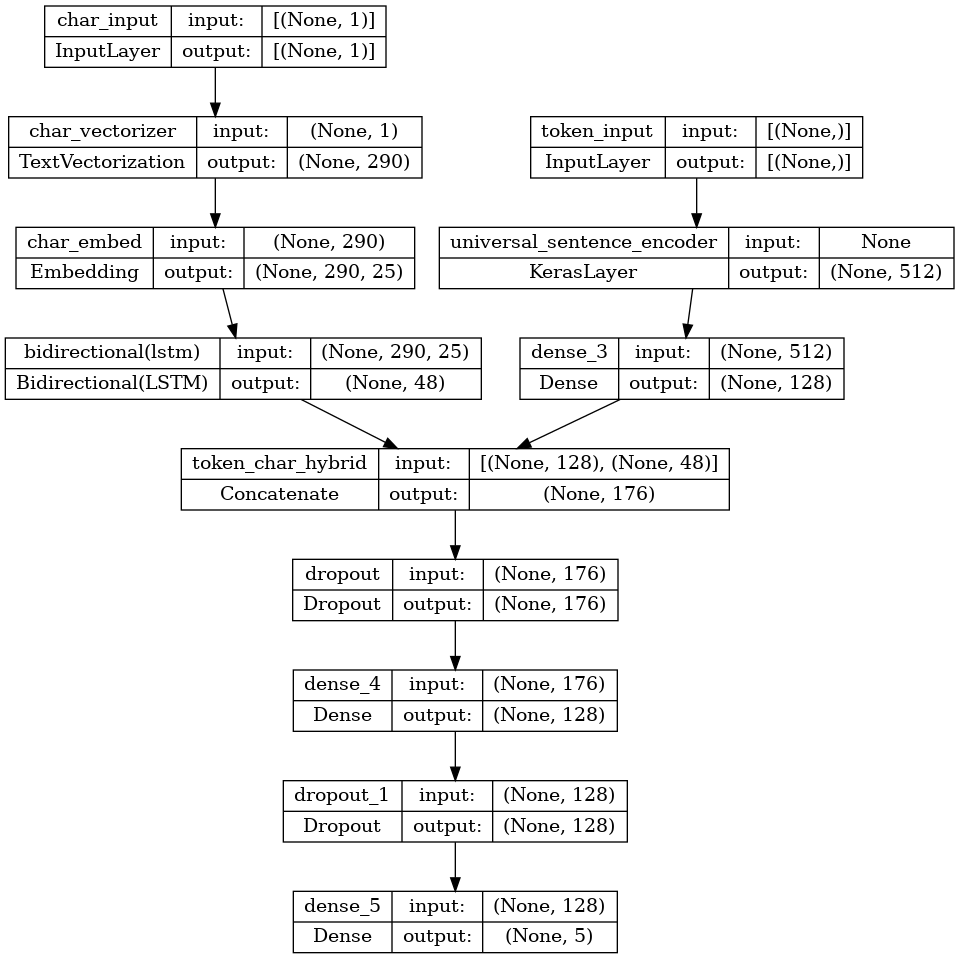

In [86]:
plot_model(model_4, show_shapes=True)

In [87]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want to try this
                metrics=["accuracy"])

# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 71s 111ms/step - loss: 0.9885 - accuracy: 0.6051 - val_loss: 0.7998 - val_accuracy: 0.6978
Epoch 2/3
562/562 [==============================] - 59s 105ms/step - loss: 0.8112 - accuracy: 0.6876 - val_loss: 0.7268 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - 59s 105ms/step - loss: 0.7810 - accuracy: 0.6990 - val_loss: 0.7051 - val_accuracy: 0.7374


In [88]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 23s 25ms/step - loss: 0.7069 - accuracy: 0.7287


[0.706876814365387, 0.7286839485168457]

In [89]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 27s 26ms/step


array([[4.4758856e-01, 3.2036951e-01, 5.0851619e-03, 2.2173505e-01,
        5.2216738e-03],
       [3.2915488e-01, 4.9568853e-01, 2.8114407e-03, 1.7134640e-01,
        9.9883857e-04],
       [2.5623339e-01, 1.0750395e-01, 5.0358575e-02, 5.5406481e-01,
        3.1839300e-02],
       ...,
       [7.1955181e-04, 9.4752582e-03, 7.2915241e-02, 2.4977958e-04,
        9.1664022e-01],
       [7.3425635e-03, 5.7197221e-02, 1.8828300e-01, 3.3887248e-03,
        7.4378848e-01],
       [3.4121585e-01, 4.3665922e-01, 1.5417039e-01, 1.6609237e-02,
        5.1345311e-02]], dtype=float32)

In [90]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [91]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 72.86839666357739,
 'precision': 0.731089924858713,
 'recall': 0.7286839666357738,
 'f1': 0.7251660770574083}

<a name="7.5"></a>
### <font color = 'orange'> 7.5. Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings</font> 



Vamos a incluir positional embeddings, pues el orden es importante; si una sentencia es la primera de un abstract es + probable que sea el objetivo o el background, si es la final la conclusión...

In [92]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑 **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [93]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

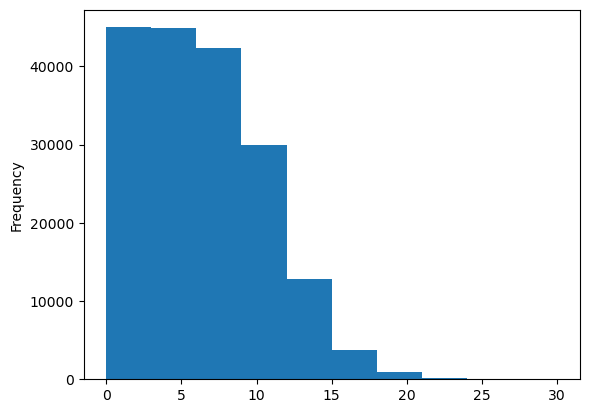

In [94]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [95]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape


# lo cortamos en 15 para que el vector no sea tan largo, y como se ve en el histograma anterior
# la mayoría cae allí



(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [96]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

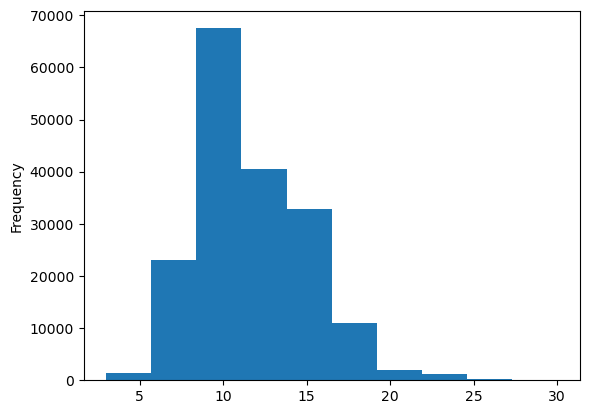

In [97]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [98]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [99]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities 
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [100]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [112]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [116]:
# Utiliza el método take(1) para obtener solo el primer elemento
first_element_dataset = train_char_token_pos_dataset.take(1)

# Convierte el dataset resultante a una lista y obtén el primer elemento
first_element = list(first_element_dataset.as_numpy_iterator())[0]

first_element

((array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

In [101]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
# dense layer with 32 units & relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [102]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

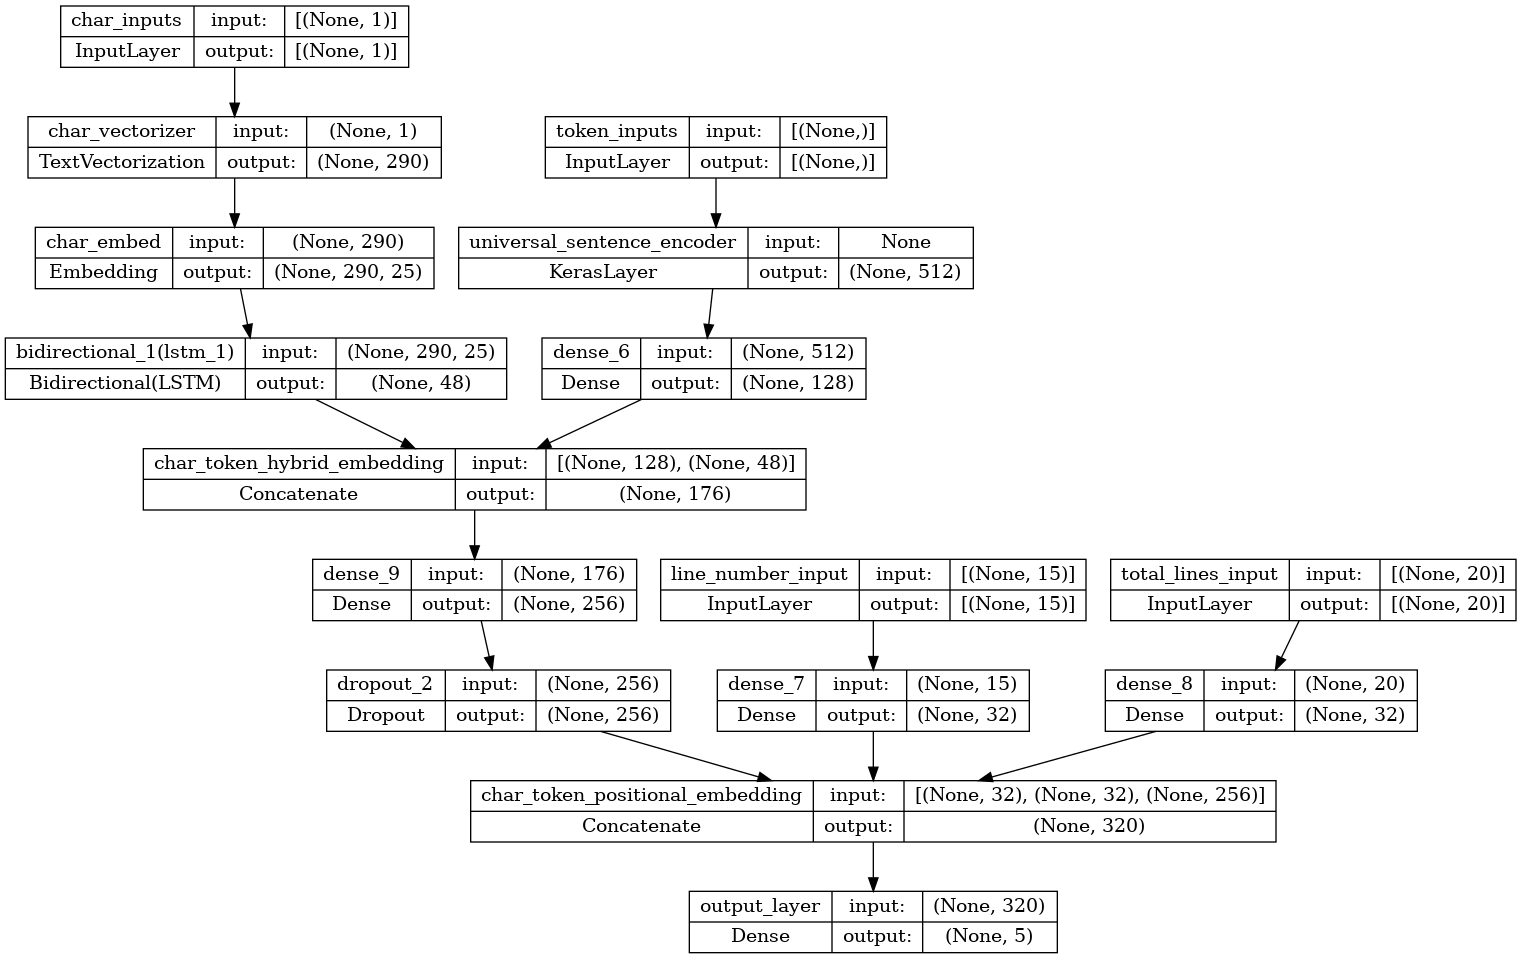

In [103]:
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]` 

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]` 

> 📖 **Resource:** For more on label smoothing, see this blog post from PyImageSearch: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/ 

In [104]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 74s 118ms/step - loss: 1.1003 - accuracy: 0.7186 - val_loss: 0.9910 - val_accuracy: 0.7979
Epoch 2/3
562/562 [==============================] - 63s 112ms/step - loss: 0.9707 - accuracy: 0.8121 - val_loss: 0.9538 - val_accuracy: 0.8255
Epoch 3/3
562/562 [==============================] - 63s 111ms/step - loss: 0.9511 - accuracy: 0.8221 - val_loss: 0.9388 - val_accuracy: 0.8311


In [105]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 26s 25ms/step


array([[0.47493747, 0.11726248, 0.01499031, 0.37117958, 0.02163012],
       [0.46632   , 0.101727  , 0.03778194, 0.3850518 , 0.00911931],
       [0.26779753, 0.12563984, 0.14016469, 0.40374446, 0.06265358],
       ...,
       [0.03875945, 0.09829523, 0.04212368, 0.03227577, 0.7885459 ],
       [0.02165781, 0.29700345, 0.08429278, 0.02166076, 0.57538515],
       [0.18690811, 0.6134957 , 0.10635643, 0.03555573, 0.05768408]],
      dtype=float32)

In [106]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [107]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.26823778631007,
 'precision': 0.8311493577653447,
 'recall': 0.8326823778631007,
 'f1': 0.8316364282457989}

<a name="8"></a>
## <font color = '#800080'> 8. Compare model results </font>

In [108]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.521779,0.782400,0.785218,0.783163
model_2_pretrained_token_embedding,78.637627,0.784583,0.786376,0.785211
model_3_custom_char_embedding,44.988746,0.375287,0.449887,0.392276
model_4_hybrid_char_token_embedding,72.868397,0.731090,0.728684,0.725166
model_5_pos_char_token_embedding,83.268238,0.831149,0.832682,0.831636


In [109]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

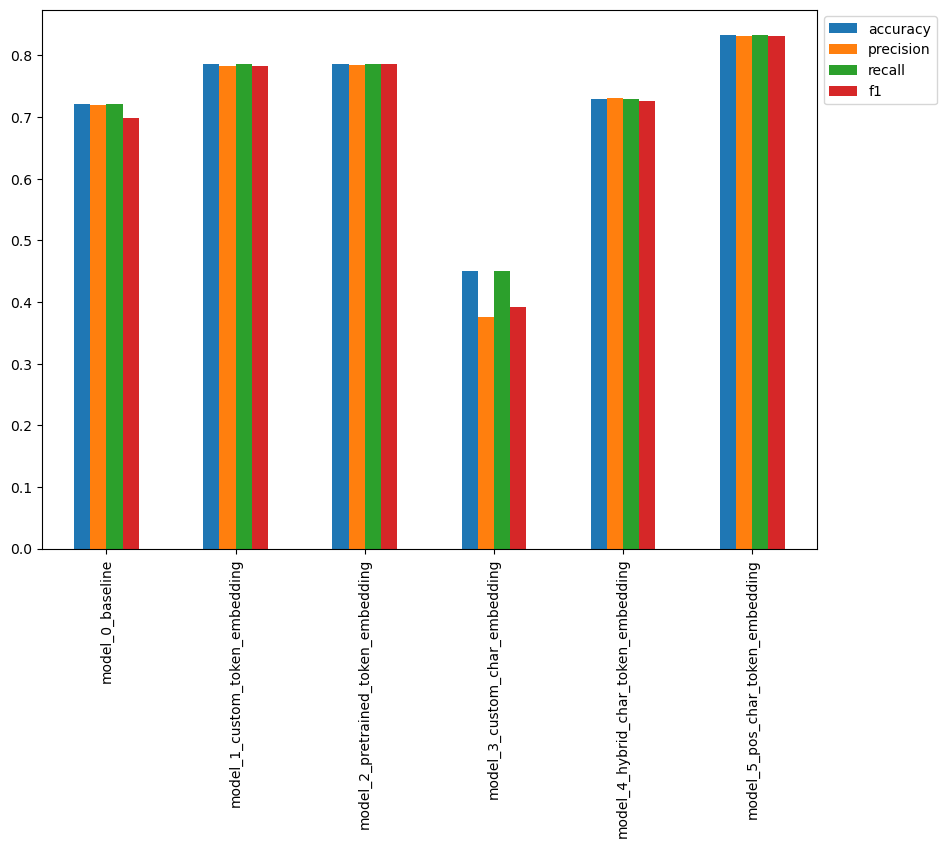

In [110]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

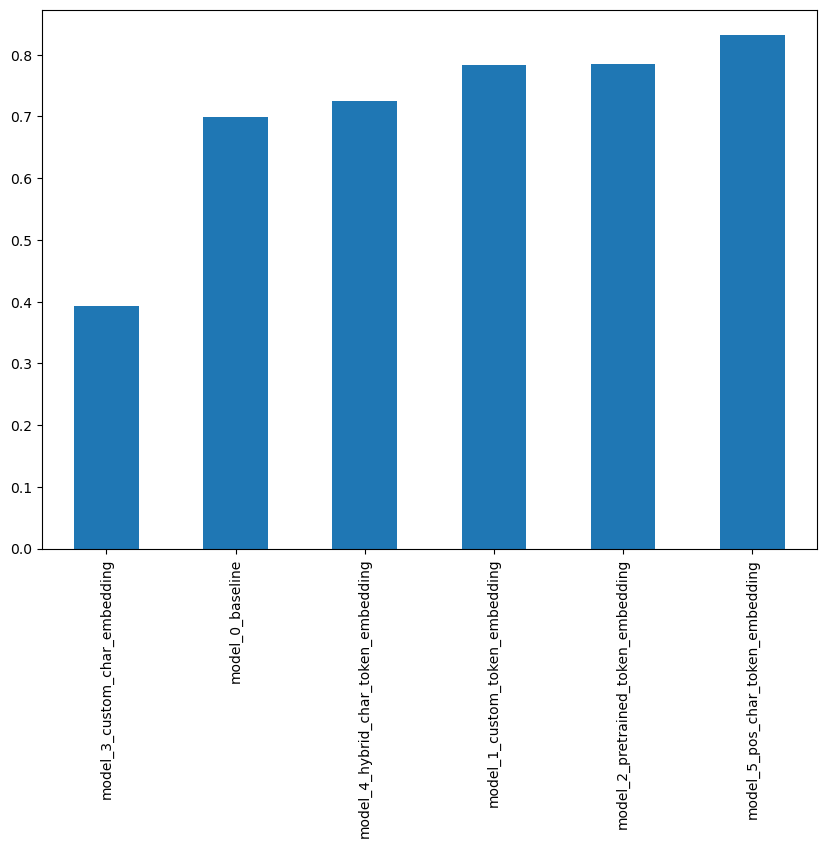

In [111]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));

<a name="9"></a>
## <font color = '#800080'> 9. References </font>


[TF Developer Certificate: ZTM](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/)